# Exam project: Scraping job postings from Jobindex

This notebook is used for webscraping www.jobindex.dk for all job postings in the period xxxx-2020. 

In [8]:
# Import necessary modules
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

#Make log
import scraping_class
logfile = 'log_jobindex_scraping.txt'
connector = scraping_class.Connector(logfile)

#Define todays date
from datetime import date
today = date.today().strftime("%Y%m%d") # to get format 20080101

### Define the maximum page number to do a FOR loop through
Each page of www.jobindex.dk/jobsoegning contains 20 joblistings. Since the number of job postings differ from time to time, so does the number of pages. To be able to scrape job postings on all pages, we look at the pagination. The pagination looks as the picture below, and we want to save the number of the last page as "last_page" to be able to loop through it later on.  
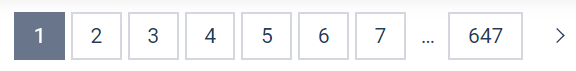

In [9]:
#Define the url and fetch the HTML using the requests module
url = 'https://www.jobindex.dk/jobsoegning?lang=da.html'
response = requests.get(url)  
html = response.text  
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

#Find the pagination and extract the text-part of the pagination links, i.e. not the link but the page number. 
pagination = soup.find_all('a', {'class':'page-link'})
last_page = int(pagination[-1].text) #Save the last page number as "last page"
print(last_page)

656


### Extract all job postings from www.jobindex.dk. 
For each job posting one is redirected from www.jobindex.dk/jobsoegning to a separate www-webpage or PDF, that contains the full job posting. We therefore have to distinguish between these two.

In [10]:
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import slate3k as slate
import pandas as pd

jobindex_links = []
for i in range(1,3): # NOTE I'm only testing it on the first two pages. Use last_page when ready
    url = f'https://www.jobindex.dk/jobsoegning?lang=da?page={i}.html'
    jobindex_links.append(url)   
#print(jobindex_links)
html = []
job_links = []
jobs = []
dates = []

for url in jobindex_links:
    response = requests.get(url)  
    html = response.text  
    soup = BeautifulSoup(html,'lxml')
    #one job result is given by class=jobsearch-result
    joblistings = soup.find_all('div',{'class':'jobsearch-result'})
    #print(joblistings)
    for joblisting in joblistings:
        title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
        links = re.findall("href=[\"\'](.*?)[\"\']", str(joblisting))
        link = str(links[1])
        link = link.replace("&amp;", "&")
        pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))
        dates.append(pub_date) 
        job = [title,link,pub_date]
        jobs.append(job) # Jobs is a list of list where each list contains the title job, and the link for that job, this will help later
        job_links.append(link)

for i in range(len(job_links)):
    if 'pdf' in jobs[i][1]:
        #scraping a PDF file
        #request the url
        url = jobs[i][1]
        response = requests.get(url)
        #save the pdf in the current folder
        with open('pdf.pdf', 'wb') as f:
            f.write(response.content)
        #open the pdf and get the text in doc
        with open('pdf.pdf', 'rb') as fp:
            doc = slate.PDF(fp)
            doc = str(doc).replace('\n','')
            doc = str(doc).replace('\r','')
            jobs[i].append(doc)
    else:
        link = jobs[i][1]
        response = requests.get(link)
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        description = soup.get_text()
        description = description.replace('\n','')
        description = description.replace('\r','')
        jobs[i].append(description)
    
    print('Completed %d/%d job_links' % (i,len(job_links)))

#transforming into dataframe
df = pd.DataFrame(jobs)
df.columns = ["Job Title", "Link","Date", "Description",]


Completed 0/40 job_links
Completed 1/40 job_links
Completed 2/40 job_links
Completed 3/40 job_links
Completed 4/40 job_links
Completed 5/40 job_links
Completed 6/40 job_links
Completed 7/40 job_links
Completed 8/40 job_links
Completed 9/40 job_links
Completed 10/40 job_links
Completed 11/40 job_links
Completed 12/40 job_links
Completed 13/40 job_links
Completed 14/40 job_links
Completed 15/40 job_links
Completed 16/40 job_links
Completed 17/40 job_links
Completed 18/40 job_links
Completed 19/40 job_links
Completed 20/40 job_links
Completed 21/40 job_links
Completed 22/40 job_links
Completed 23/40 job_links
Completed 24/40 job_links
Completed 25/40 job_links
Completed 26/40 job_links
Completed 27/40 job_links
Completed 28/40 job_links
Completed 29/40 job_links
Completed 30/40 job_links
Completed 31/40 job_links
Completed 32/40 job_links
Completed 33/40 job_links
Completed 34/40 job_links
Completed 35/40 job_links
Completed 36/40 job_links
Completed 37/40 job_links
Completed 38/40 job_li

## Identifying jobs with possibility of working remotely

In [473]:
# First we define a list of keyword that we think a job posting where working remotely is a possibility will include

keywords = ['hjemmefra', 'arbejde hjemme', 'hjemmearbejde','hjemmekontor', 'arbejde hjemmefra', 'arbejde remote', 'fjernarbejde']

# I will now look for these words in the description column. I am not using the tokenized version of column because then I 
# can't look for expressions with more than one word. If you want to use the tokenized version then you have to use bigrams

df['Remote'] = '0'
for word in keywords:
    for i in range(len(df)):
        df['Description'][i] = str(df['Description'][i]).lower()
        if word in df['Description'][i]:
            df['Remote'][i] = '1'
            
        

## Identifying the most popular words in job descriptions

In [527]:
# The first step is to clean the job descriptions as much as possible so we can narrow down the words included for 
# analysis as much as possible

df['Tokenized_description'] = ' '
symbols = ['?','!','>','<','-','[',']','(',')','{','}',' –','``',"''",'""','\\','@','$','&','=']
for i in range(len(df)):
    stop_words = nltk.corpus.stopwords.words("danish")
    df['Tokenized_description'][i] = re.sub(r'(\.+ )|,|\||:|/|\'|\-|;|\*|!|(\s\d+\s)|(\s\W\s)',' ',str(df['Description'][i]))
    df['Tokenized_description'][i] = str(df['Tokenized_description'][i]).rstrip('\\')
    df['Tokenized_description'][i] = nltk.word_tokenize(str(df['Tokenized_description'][i].lower()))
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words] 
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in symbols]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w.isnumeric()]
    df['Tokenized_description'][i] = [word for word in df['Tokenized_description'][i] if len(word) > 3]
    
# Finding intersections --- USELESS
df['description_set'] = df['Tokenized_description'].apply(set)
description_set = df['description_set'].tolist() #convert each description into a set 
set.intersection(*description_set)
del df['description_set']

# Finding most frequent words in all descriptions --- USELESS ATM BUT MAYBE IF WE CLEAN IT ENOUGH IT WILL WORK

descriptions_list = [] 
# This loop will pull all tokens in one bag
for i in range(len(df)):
    descriptions_list.extend(df['Tokenized_description'][i]) 
    
word_dist = nltk.FreqDist(descriptions_list) word_dist

In [ ]:
# CELL DEDICATED TO KEEP CLEANING DESCRIPTIONS

def clean(doc):
    #doc = doc.replace('\n','')
    #doc = doc.replace('\r','')
    doc = doc.replace('\t','')
    doc = doc.replace('\'','')
    doc = doc.replace('|','')
    doc = doc.replace('/','')

def strip_html(row):
    return str(html.fromstring(row).text_content())

from lxml import html
for row in df['Description']:
    strip_html(str(row))
    
    
    
#text = re.sub('<[^>]*>', '', text)
#emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

## Assigning DISCO-08 codes to the job postings
This function will be used to assign a DISCO-08 code to the job postings. It goes through the following steps:

1. Importing a csv file downloaded from Danmarks Statistik which includes the different job functions that fall under each DISCO-08 category
2. Clean this csv file and converting it into a dataframe with two columns, one that has the disco codes and one that has a list of all the jobs that fall into each code
3. Tokenizing the jobs 
4. Tokenizing the words in the 'Job Title' column from our job postings data
5. Creating a function that compares the tokens in the job titles to the tokens in the DISCO dataframe and if a match is found, then returning the corresponding DISCO code

In [319]:
# Importing and cleaning DISCO-08 classification
import pandas as pd
import re
disco = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\csv_da.csv",header=None)
disco_clean = disco.copy()

# Remove words that start with lowercase
for i in range(len(disco_clean)):
    disco_clean[3][i] = ' '.join([word for word in str(disco_clean[3][i]).split(' ') if not word.islower()])

# Create a dictionary for DISCO functions

disco_clean['DISCO'] = disco_clean[0].astype(str).str[:1] #This column will have the highest hierarchy code 0-9
del disco_clean[0]
del disco_clean[1]
del disco_clean[2]
disco_clean = disco_clean.groupby(by=disco_clean['DISCO']).sum()
disco_clean.rename({3:'functions'}, axis='columns', inplace = True) # rename column 
for i in range(9): # Adding a space in between words that are missing them "LikeThis"
    disco_clean['DISCO'] = disco_clean['DISCO'].astype(str).str[:1] # We only want the first number 
    disco_clean['functions'][i] = re.sub(r"(\w)([A-Z])", r"\1 \2", str(disco_clean['functions'][i]))
    
disco_clean["functions_tokenized"] = ""
for i in range(len(disco_clean)):
    disco_clean['functions_tokenized'][i]=nltk.word_tokenize(str(disco_clean['functions'][i]).lower())
    
# Now I would like a job type column from the job titles where I would extract the nouns from job titles
#pip install afinn
import nltk
df['Job Title']=df['Job Title'].str.replace(',','')
df["tokenized_titles"] = ""
for i in range(len(df)):
    df['tokenized_titles'][i] = nltk.word_tokenize(str(df['Job Title'][i]).lower())

# This loop creates a new column in the df that assigns a disco code to each posting based on the words in the title

df['disco'] = ''
for m in range(len(df)):
    for i in range(len(disco_clean)):
        for element in disco_clean['functions_tokenized'][i]:
            if element in df['tokenized_titles'][m]:
                df['disco'][m] = disco_clean['DISCO'][i]

C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Scrape the joblistings for each geographical area and job categories/industries
www.jobindex.dk/jobsoegning has a filter for geographical area and job category, respectively. These can be seen in the picture below. We will scrape this to be able to describe in which areas and industries remote working is especially taking place. The address of the company is also attached to the job posting, and even though this information would be more detailed, we have experienced that the address often belongs to the headquarter of the company and not the specific area, where the job is. Therefore we use the information from the geographical filter.
We will loop through the filters and extract job titles and company, which can then be merged onto the big dataframe.

In [13]:
import re
import requests
from datetime import date
from bs4 import BeautifulSoup
import numpy as np

#Define the basic url
url = 'https://www.jobindex.dk/jobsoegning'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html,'lxml')

#Areas are given in the html by div id=areas and class=area_label
areas_html = soup.find('div', {'id':'areas'})#('a', {'class':'area_label'})
areas_div = str(areas_html).split('href="/jobsoegning/')[1:]

#Find the names of each of the areas
areas = ()
areas_delete = ('skaane', 'faeroeerne', 'udlandet', 'groenland', 'danmark') #delete regions outside Denmark's borders
for area in areas_div:
    link = area.split('"')[0]
    if link in areas_delete:
        del link
    else:
        areas += (link,)
areas += ('danmark',) #make sure Danmark is the last element in the tuple, since it is ordered. 
#print(areas)

#Categories are given in the html by and id=categories
cat_html = soup.find('div', {'id':'categories'})
cat_div = soup.find_all('a',{'class':'filter-section-header title collapsed'}) #the filter collapses

categories = []
subcategories = []
for cat in cat_div:
    #first find the overall categories
    cat_name = re.findall(r'(?<=<span>)(.*)(?=<span class)', str(cat))[0]
    cat_name = cat_name.replace('\xad','')
    cat_links = re.findall("href=[\"\'](.*?)[\"\']", str(cat))
    cat_id = str(cat_links[0])
    cat_id = cat_id.replace('#','')
    category = [cat_name,cat_id]
    categories.append(category)
    #next find the sub-categories
    subcat_div = str(cat_html).split('href="/jobsoegning/')[1:]
for subcat in subcat_div:
    subcategory = subcat.split('"')[0]
    #cat_id = re.findall('(.*?)/', str(subcategory))
    #subcat_done = [subcategory,cat_id]
    subcategories.append(subcategory)
#print(categories)
#print(subcategories)
    

In [18]:
import math
import time
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

#Scraping the areas and categories from jobindex.
#quarters = [['0101','0331'],['0401','0630'],['0701','0930'],['1001','1231']]
#years = ['18','19','20']
remotely = ['hjemmekontor','hjemmearbejde','fjernarbejde','arbejde%2Bhjemmefra','arbejde%2Bhjemme','remote%2Barbejdsplads','remote%2Bwork','work%2Bremotely', 'working%2Bremotely','working%2Bfrom%2Bhome', 'home%2Boffice','home-office']
today = date.today().strftime("%Y%m%d") # to get format 20080101
jobs = []

#for y in years: #Loop through each year    
#for q in quarters: #Loop through each quarter
for area in areas:
    for subcategory in subcategories:
        print('Now requesting url: ' + subcategory +' and '+ area)
        for remote in remotely:
            url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate=20150101&q={remote}'
            response = requests.get(url) 
            soup = BeautifulSoup(response.text,'lxml')
        
            #Identify total number of job postings in the given quarter
            pages = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text() 
            total = re.findall(r'af(?s)(.*)resultat',str(pages))
            total = str(total).strip("[]").strip("''").strip().replace('.','')
            if total == 0:
                continue
            #Use total number of job postings to calculate total number of pages
            last_page = math.ceil(int(total)/20)
        
            #Loop through pages
            for page in range(1,last_page+1):
                if  page % 20 == 0:
                    print('Now scraping page: ',page,'/', last_page, ' for ', subcategory, ' and ', area)
                url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate=20150101&page={page}&q={remote}'
                response = requests.get(url)  
                html = response.text   
                if '<strong>' in html: 
                    html = html.replace('<strong>','<b>')\
                                .replace('</strong>','</b>')
                else:
                    print('No <strong>')
                soup = BeautifulSoup(html,'lxml') 
                joblistings = soup.find_all('div',{'class':'jobsearch-result'}) 
                        
                for joblisting in joblistings: #Loop through job listings
                    #Find title
                    title = re.findall(r'<b>(.*?)</b>', str(joblisting))[0]
                    if 'amp;' in title:
                        title = title.replace('amp;','')
                    #Find company name
                    if len(re.findall(r'<b>(.*?)</b>', str(joblisting)))>1:
                        company = re.findall(r'<b>(.*?)</b>', str(joblisting))[1]
                        if 'amp;' in company:
                            company = company.replace('amp;','') 
                    #Find publication date
                    pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))[0]
                    geo_area = area #Save geographical area
                    cat_id = re.findall('(.*?)/', str(subcategory))[0] #Save category 
                    subcat_id = subcategory #Save subcategory
                    remote_word = remote
                    #Find link to job posting
                    descrip = BeautifulSoup(str(joblisting), 'lxml')
                    for div in descrip.find_all("div", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                        div.decompose()
                    for span in descrip.find_all("span", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                        span.decompose()
                    links = re.findall("href=[\"\'](.*?)[\"\']", str(descrip))
                    if len(links)>1:
                        link = str(links[1])
                    else:
                        link = str(links[0])
                    link = link.replace("&amp;", "&")
                    # Indirectly extracting the short job description by removing everything else
                    descrip = descrip.get_text()
                    descrip = descrip.replace("\n", " ") # remove \n
                    job = [title, company, pub_date, remote_word, geo_area, cat_id, subcat_id, link, descrip]
                    jobs.append(job)
    df = pd.DataFrame(jobs)
    df.columns = ['Job Title','Company','Publication Date','Remote word','Geographical Area','Job Category','Job Subcategory', 'Link', 'Description']
    df.to_pickle(r'C:\Users\miche\Dropbox\KU Introduction to Social Data Science\Modules\Jobs_basic_info18-20')
    print('Finished area: ',area)
 

Now requesting url: it/database and storkoebenhavn
Now requesting url: it/itdrift and storkoebenhavn
Now requesting url: it/itkurser and storkoebenhavn
Now requesting url: it/itledelse and storkoebenhavn
Now requesting url: it/internet and storkoebenhavn
Now requesting url: it/systemudvikling and storkoebenhavn
Now requesting url: it/telekom and storkoebenhavn
Now requesting url: it/virksomhedssystemer and storkoebenhavn
Now requesting url: ingenioer/byggeteknik and storkoebenhavn
Now requesting url: ingenioer/elektronik and storkoebenhavn
Now requesting url: ingenioer/kemi and storkoebenhavn
Now requesting url: ingenioer/teknikledelse and storkoebenhavn
Now requesting url: ingenioer/maskiningenioer and storkoebenhavn
Now requesting url: ingenioer/medicinal and storkoebenhavn
Now requesting url: ingenioer/produktionsteknik and storkoebenhavn
Now requesting url: ledelse/detailledelse and storkoebenhavn
Now requesting url: ledelse/freelancekonsulent and storkoebenhavn
Now requesting url:

Now requesting url: industri/industri and nordsjaelland
Now requesting url: industri/jern and nordsjaelland
Now requesting url: industri/lager and nordsjaelland
Now requesting url: industri/landbrug and nordsjaelland
Now requesting url: industri/maling and nordsjaelland
Now requesting url: industri/mekanik and nordsjaelland
Now requesting url: industri/naeringsmiddel and nordsjaelland
Now requesting url: industri/tekstil and nordsjaelland
Now requesting url: industri/transport and nordsjaelland
Now requesting url: industri/traeindustri and nordsjaelland
Now requesting url: industri/toemrer and nordsjaelland
Now requesting url: salg/design and nordsjaelland
Now requesting url: salg/ejendomsmaegler and nordsjaelland
Now requesting url: salg/grafisk and nordsjaelland
Now requesting url: salg/kommunikation and nordsjaelland
Now requesting url: salg/kultur and nordsjaelland
Now requesting url: salg/marketing and nordsjaelland
Now requesting url: salg/salg and nordsjaelland
Now requesting ur

Now requesting url: kontor/oversaettelse and region-sjaelland
Now requesting url: kontor/sekretaer and region-sjaelland
Now requesting url: kontor/oekonomi and region-sjaelland
Now requesting url: ledelse/oekonomichef and region-sjaelland
Now requesting url: social/laege and region-sjaelland
Now requesting url: social/laegesekretaer and region-sjaelland
Now requesting url: kontor/offentlig and region-sjaelland
Now requesting url: social/pleje and region-sjaelland
Now requesting url: social/psykologi and region-sjaelland
Now requesting url: social/socialraadgivning and region-sjaelland
Now requesting url: social/sygeplejerske and region-sjaelland
Now requesting url: social/tandlaege and region-sjaelland
Now requesting url: social/teknisksundhed and region-sjaelland
Now requesting url: social/terapi and region-sjaelland
Now requesting url: oevrige/elev and region-sjaelland
Now requesting url: oevrige/forsvar and region-sjaelland
Now requesting url: oevrige/frivilligt and region-sjaelland

Now requesting url: handel/hotel and region-nordjylland
Now requesting url: handel/rengoering and region-nordjylland
Now requesting url: handel/service and region-nordjylland
Now requesting url: handel/sikkerhed and region-nordjylland
Now requesting url: industri/blik and region-nordjylland
Now requesting url: industri/byggeri and region-nordjylland
Now requesting url: industri/elektriker and region-nordjylland
Now requesting url: industri/industri and region-nordjylland
Now requesting url: industri/jern and region-nordjylland
Now requesting url: industri/lager and region-nordjylland
Now requesting url: industri/landbrug and region-nordjylland
Now requesting url: industri/maling and region-nordjylland
Now requesting url: industri/mekanik and region-nordjylland
Now requesting url: industri/naeringsmiddel and region-nordjylland
Now requesting url: industri/tekstil and region-nordjylland
Now requesting url: industri/transport and region-nordjylland
Now requesting url: industri/traeindustr

Now requesting url: undervisning/forskning and region-midtjylland
Now requesting url: ledelse/institutions and region-midtjylland
Now requesting url: undervisning/laerer and region-midtjylland
Now requesting url: undervisning/paedagog and region-midtjylland
Now requesting url: undervisning/voksenuddannelse and region-midtjylland
Now requesting url: kontor/akademisk and region-midtjylland
Now requesting url: salg/ejendomsmaegler and region-midtjylland
Now requesting url: handel/ejendomsservice and region-midtjylland
Now requesting url: kontor/finans and region-midtjylland
Now requesting url: kontor/indkoeb and region-midtjylland
Now requesting url: kontor/jura and region-midtjylland
Now requesting url: kontor/kontor and region-midtjylland
Now requesting url: kontor/kontorkurser and region-midtjylland
Now requesting url: kontor/kontorelev and region-midtjylland
Now requesting url: kontor/logistik and region-midtjylland
Now requesting url: kontor/offentlig and region-midtjylland
Now reque

Now requesting url: it/virksomhedssystemer and bornholm
Now requesting url: ingenioer/byggeteknik and bornholm
Now requesting url: ingenioer/elektronik and bornholm
Now requesting url: ingenioer/kemi and bornholm
Now requesting url: ingenioer/teknikledelse and bornholm
Now requesting url: ingenioer/maskiningenioer and bornholm
Now requesting url: ingenioer/medicinal and bornholm
Now requesting url: ingenioer/produktionsteknik and bornholm
Now requesting url: ledelse/detailledelse and bornholm
Now requesting url: ledelse/freelancekonsulent and bornholm
Now requesting url: ledelse/hrkurser and bornholm
Now requesting url: it/itledelse and bornholm
Now requesting url: ledelse/institutions and bornholm
Now requesting url: ledelse/leder and bornholm
Now requesting url: ingenioer/teknikledelse and bornholm
Now requesting url: ledelse/personale and bornholm
Now requesting url: ledelse/projektledelse and bornholm
Now requesting url: ledelse/salgschef and bornholm
Now requesting url: ledelse/to

Now requesting url: salg/franchise and danmark
Now requesting url: salg/telemarketing and danmark
Now requesting url: undervisning/bibliotek and danmark
Now requesting url: undervisning/forskning and danmark
Now requesting url: ledelse/institutions and danmark
Now requesting url: undervisning/laerer and danmark
Now requesting url: undervisning/paedagog and danmark
Now requesting url: undervisning/voksenuddannelse and danmark
Now requesting url: kontor/akademisk and danmark
Now requesting url: salg/ejendomsmaegler and danmark
Now requesting url: handel/ejendomsservice and danmark
Now requesting url: kontor/finans and danmark
Now requesting url: kontor/indkoeb and danmark
Now requesting url: kontor/jura and danmark
Now requesting url: kontor/kontor and danmark
Now requesting url: kontor/kontorkurser and danmark
Now requesting url: kontor/kontorelev and danmark
Now requesting url: kontor/logistik and danmark
Now requesting url: kontor/offentlig and danmark
Now requesting url: kontor/overs

In [26]:
import pandas as pd
import datetime

unpickled_df = pd.read_pickle(r'C:\Users\miche\Dropbox\KU Introduction to Social Data Science\Modules\Jobs_basic_info18-20')
print(unpickled_df['Link'])
print('Length of dataset: ',len(unpickled_df))

#Removing duplicated step by step
#Dropping completely duplicte entries 
dupl1 = unpickled_df.drop_duplicates(keep = 'first')
print('Length after dropping all complete duplicates: ', len(dupl1))

#Drop duplicate entries based on all columns besides remote word (=> same job posting could occur in multiple searchings)
dupl2 = dupl1.drop_duplicates(subset=['Job Title','Company','Publication Date','Geographical Area','Job Category','Job Subcategory','Link','Description'], keep = 'first')
print('Length after dropping duplicates on remote word: ',len(dupl2))

#Drop duplicate entries based on all columns besides category and subcategory (=> same job could occur in more categories)
dupl3 = dupl2.drop_duplicates(subset=['Job Title','Company','Publication Date', 'Remote word','Geographical Area','Link','Description'], keep = 'first')
print('Length after dropping duplicates on category and subcategory: ',len(dupl3))

#Drop duplicate entries based on all columns besides remote word and geographical area (=> same job could occur)
#Be aware that the same job posting can be in more areas
dupl4 = dupl3.drop_duplicates(subset=['Job Title','Company','Publication Date','Remote word','Job Category','Job Subcategory','Link','Description'], keep = 'first')
print('Length after dropping duplicates on geographical area: ',len(dupl4))

final_data = dupl4

0        https://www.jobindex.dk/jobannonce/323154/data...
1        https://www.jobindex.dk/jobannonce/303710/app-...
2        https://www.jks.dk/Jobannonce.asp?AjrDcmntId=2...
3        https://www.nomeco.dk/da/ledige-stillinger?hr=...
4        https://www.nomeco.dk/da/ledige-stillinger?hr=...
                               ...                        
35795    https://mascot.easycruit.com/vacancy/1755405/1...
35796    http://mascot.easycruit.com/vacancy/1755405/16...
35797    http://www.jobzonen.dk/job/6918609/escalation-...
35798    http://www.ofir.dk/Resultat/dnisch-und-deutsch...
35799     http://www.jobindex.dk/jobannonce/jobnet/6616976
Name: Link, Length: 35800, dtype: object
Length of dataset:  35800
Length after dropping all complete duplicates:  34395
Length after dropping duplicates on remote word:  30774
Length after dropping duplicates on category and subcategory:  22933
Length after dropping duplicates on geographical area:  9371
